In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_N_sheet

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


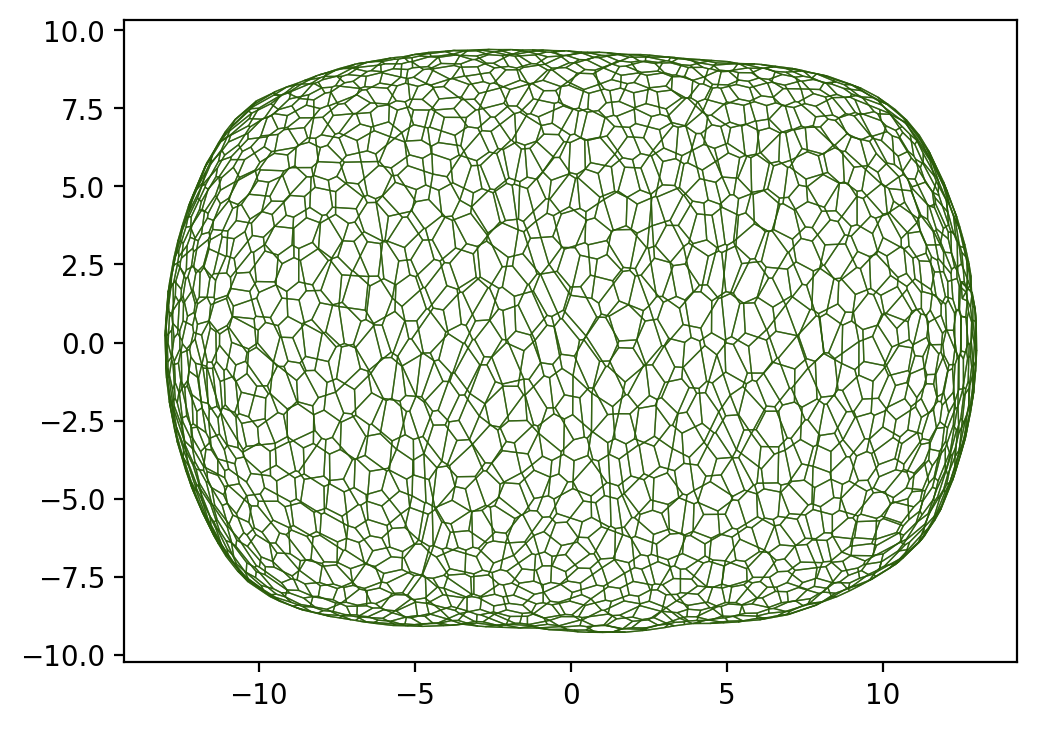

In [4]:
specs['settings']["barrier_radius"] = 13
sheet.update_specs(specs, reset=True)
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
fig, ax = sheet_view(sheet, coords=["z", "x"])

In [5]:
lumen_vol_egg= []
theta = np.pi / 3
be = np.arange(1, 300, 50)
sheets_obj = {}

for i, sheet.settings['barrier_elasticity'] in enumerate(be):
    sheet_copy=sheet.copy()
    print(f"{i+1} / {10}", end=" ")
    update_weights(sheet_copy, threshold_angle=theta, below_threshold=1, above_threshold=1,
    )
    sheet.settings['barrier_elasticity']=sheet.settings['barrier_elasticity']
    geom.update_all(sheet)
    solver = QSSolver(with_t1=True, with_t3=False)
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
    lumen_vol_egg.append(sheet_copy.settings['lumen_vol'])
    sheet_copy = sheet.copy()
    sheets_obj[sheet.settings['barrier_elasticity']] = sheet_copy


lumen_vol_egg = np.array(lumen_vol_egg)
print(lumen_vol_egg)


1 / 10 2 / 10 3 / 10 4 / 10 5 / 10 6 / 10 [5626.76801752 5663.31448025 5676.53477192 5693.53800405 5694.26737785
 5695.09220626]


<function matplotlib.pyplot.show(close=None, block=None)>

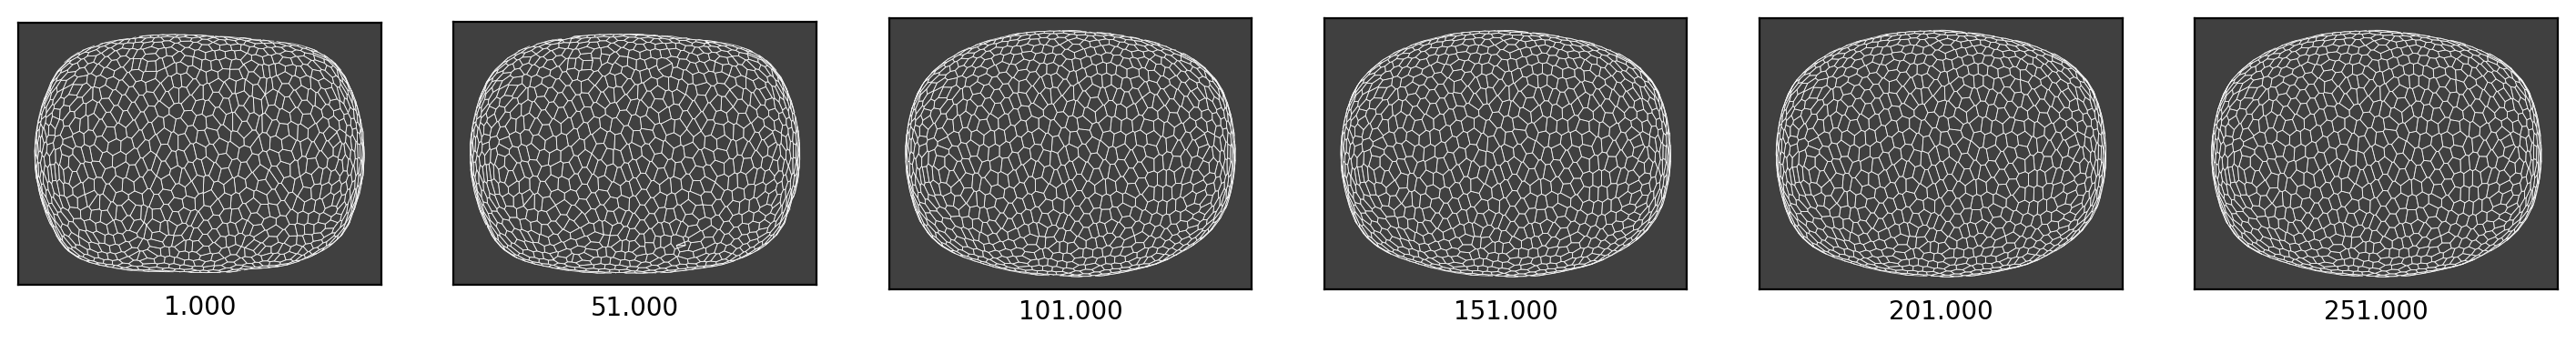

In [6]:
fig, axes = plt.subplots(1, 6)

for i, (sheet.settings['barrier_elasticity'], sheet_copy) in enumerate(sheets_obj.items()):
    #plt.savefig(f'sheet {i+1}.png', transparent=True)
    fig, ax = draw_half_N_sheet(sheet_copy, axes[i])
    ax.set_xlabel(f"{sheet.settings['barrier_elasticity']:.3f}")
    ax.set_facecolor('#404040')
fig.set_size_inches(18, 5)
plt.savefig('../image/barrier_elasticity.png', transparent=False)
plt.show
